In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# --- PARAMETERS ---
AIR_TRAVEL_DELAY = 12.84
respirometry_dir = Path(r"D:\Respirometry\Bumblebee\flying")

In [60]:
# --- LIST FILES ---
print("📁 Listing files in respirometry_dir:\n")
respi_files = list(respirometry_dir.glob("*_flower_corrected_secfromstart"))
if not respi_files:
    print("❌ No matching files found.")
else:
    for f in respi_files:
        print(f.name)

📁 Listing files in respirometry_dir:

Data_03-10-2025_001_red31_flower_corrected_secfromstart
Data_03-10-2025_001_unmarked33_flower_corrected_secfromstart
Data_03-10-2025_001_unmarked34_flower_corrected_secfromstart
Data_03-10-2025_001_unmarked3_flower_corrected_secfromstart
Data_03-11-2025_001_green3_flower_corrected_secfromstart
Data_03-11-2025_001_unmarked38_flower_corrected_secfromstart
Data_03-12-2025_001_unmarked302_flower_corrected_secfromstart
Data_03-12-2025_001_unmarked303_flower_corrected_secfromstart
Data_03-20-2025_001_green4_flower_corrected_secfromstart
Data_03-20-2025_001_unmarked40_flower_corrected_secfromstart
Data_03-20-2025_001_unmarked41_flower_corrected_secfromstart
Data_03-20-2025_001_unmarked42_flower_corrected_secfromstart
Data_03-20-2025_001_unmarked43_flower_corrected_secfromstart
Data_03-20-2025_001_unmarked44_flower_corrected_secfromstart
Data_03-20-2025_001_unmarked46_flower_corrected_secfromstart
Data_03-20-2025_001_unmarked47_flower_corrected_secfromstar

In [61]:
# --- LOAD BUZZING DATA ---
buzz_df = pd.read_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\buzz_label_sheet.csv")
buzz_df = buzz_df[buzz_df["is_floral_buzz"] == "yes"].copy()
buzz_df["laser_key"] = buzz_df["laser_key"].str.strip().str.lower()

In [62]:
# --- LOAD SYNC DATA ---
sync_df = pd.read_excel(r"D:\Laser\data\txt_files\flying_bees\peak_counts_in_windows.xlsx")
sync_df["laser_key"] = sync_df["file"].str.extract(r"_(\d{6})\.txt$")[0]
sync_df["laser_key"] = "_" + sync_df["laser_key"].str.strip().str.lower()

buzz_df = buzz_df.merge(sync_df[["laser_key", "first_peak_time"]], on="laser_key", how="left")
buzz_df["start_respi_s"] = buzz_df["start_laser"] - buzz_df["first_peak_time"] + AIR_TRAVEL_DELAY
buzz_df["stop_respi_s"] = buzz_df["stop_laser"] - buzz_df["first_peak_time"] + AIR_TRAVEL_DELAY

In [63]:
# --- LOAD METADATA ---
bee_meta = pd.read_excel(r"C:\Users\labadmin\Documents\Uppsala analyses\beeID laser file name + weight.xlsx", sheet_name="flying_bees")
bee_meta["laser_key"] = bee_meta["Laser file name"].str.strip().str.lower()
bee_meta["BeeID"] = bee_meta["BeeID"].str.strip().str.lower()
buzz_df = buzz_df.merge(bee_meta[["laser_key", "BeeID"]], on="laser_key", how="left")

In [64]:
# --- LOAD FLIGHT BOUTS ---
bouts_df = pd.read_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\BORIS manual labelling\flying\all_manual_flight_bouts_LV.csv")
bouts_df["BeeID"] = bouts_df["Observation id"].str.split("-").str[2].str.lower()

sync_df_flight = pd.read_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\BORIS manual labelling\respirometry syncing\respirometry_syncing.csv")
sync_df_flight["ExtractedBeeID"] = sync_df_flight["Observation id"].str.split("-").str[2].str.lower()

bouts_df = bouts_df.merge(
    sync_df_flight[["ExtractedBeeID", "Start (s)"]].rename(columns={"ExtractedBeeID": "BeeID", "Start (s)": "video_poke_time"}),
    on="BeeID",
    how="left"
)

bouts_df["start_respi_s"] = bouts_df["Start (s)"] - bouts_df["video_poke_time"] + AIR_TRAVEL_DELAY
bouts_df["stop_respi_s"] = bouts_df["Stop (s)"] - bouts_df["video_poke_time"] + AIR_TRAVEL_DELAY

In [65]:
# --- LOAD META FOR FILE MAPPING ---
meta_df = pd.read_excel(r"C:\Users\labadmin\Documents\Uppsala analyses\beeID laser file name + weight.xlsx", sheet_name="flying_bees")
meta_df["BeeID"] = meta_df["BeeID"].str.strip().str.lower()

In [66]:
# --- MAP BEEID TO FILES ---
respi_files = list(respirometry_dir.glob("*_flower_corrected_secfromstart"))
respi_map = []
pattern = re.compile(r"\d+_([a-zA-Z0-9]+)_flower_corrected")

print("\n🔍 Mapping respirometry files to BeeIDs:")
for f in respi_files:
    match = pattern.search(f.stem)
    if match:
        bee_id = match.group(1).lower()
        print(f"✅ Matched: {bee_id} → {f.name}")
        respi_map.append({"BeeID": bee_id, "respi_file": f.name})
    else:
        print(f"⚠️  No BeeID match in filename: {f.name}")

if not respi_map:
    print("\n❌ No BeeIDs matched any files.")
else:
    respi_df = pd.DataFrame(respi_map)
    meta_df = meta_df.merge(respi_df, on="BeeID", how="left")

    print("\n🗺 Final BeeID → File Map:")
    for bee_id in meta_df["BeeID"]:
        file = meta_df.loc[meta_df["BeeID"] == bee_id, "respi_file"].values[0]
        print(f"  {bee_id} → {file if pd.notna(file) else '❌ No match'}")


🔍 Mapping respirometry files to BeeIDs:
✅ Matched: red31 → Data_03-10-2025_001_red31_flower_corrected_secfromstart
✅ Matched: unmarked33 → Data_03-10-2025_001_unmarked33_flower_corrected_secfromstart
✅ Matched: unmarked34 → Data_03-10-2025_001_unmarked34_flower_corrected_secfromstart
✅ Matched: unmarked3 → Data_03-10-2025_001_unmarked3_flower_corrected_secfromstart
✅ Matched: green3 → Data_03-11-2025_001_green3_flower_corrected_secfromstart
✅ Matched: unmarked38 → Data_03-11-2025_001_unmarked38_flower_corrected_secfromstart
✅ Matched: unmarked302 → Data_03-12-2025_001_unmarked302_flower_corrected_secfromstart
✅ Matched: unmarked303 → Data_03-12-2025_001_unmarked303_flower_corrected_secfromstart
✅ Matched: green4 → Data_03-20-2025_001_green4_flower_corrected_secfromstart
✅ Matched: unmarked40 → Data_03-20-2025_001_unmarked40_flower_corrected_secfromstart
✅ Matched: unmarked41 → Data_03-20-2025_001_unmarked41_flower_corrected_secfromstart
✅ Matched: unmarked42 → Data_03-20-2025_001_unma

In [67]:
# --- PLOT FUNCTION ---
def plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id):
    bee_id = bee_id.lower()
    meta_row = meta_df[meta_df["BeeID"] == bee_id]
    if meta_row.empty or "respi_file" not in meta_row.columns or pd.isna(meta_row["respi_file"].values[0]):
        print(f"❌ No matching respirometry file found for bee '{bee_id}'")
        return

    file_name = str(meta_row["respi_file"].values[0])
    file_path = respirometry_dir / file_name

    print(f"\n📄 Loading respirometry file: {file_path}")
    try:
        trace = pd.read_csv(file_path, sep=None, engine="python")
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return

    # Flexible column detection
    if "CO2" in trace.columns:
        trace["CO2_ppm"] = trace["CO2"] * 10000
    elif "CO2_percent" in trace.columns:
        trace["CO2_ppm"] = trace["CO2_percent"] * 10000
    else:
        print("❌ Missing CO₂ column. Expected 'CO2' or 'CO2_percent'.")
        return

    if "Seconds" not in trace.columns:
        print("❌ Missing 'Seconds' column.")
        return

    buzzes = buzz_df[buzz_df["BeeID"] == bee_id]
    flights = bouts_df[bouts_df["BeeID"] == bee_id]

    plt.figure(figsize=(14, 5))
    plt.plot(trace["Seconds"], trace["CO2_ppm"], color='blue', label="CO₂ (ppm)")

    for i, row in buzzes.iterrows():
        plt.axvspan(row["start_respi_s"], row["stop_respi_s"], color="red", alpha=0.3, label="Buzzing" if i == 0 else None)

    for i, row in flights.iterrows():
        plt.axvspan(row["start_respi_s"], row["stop_respi_s"], color="yellow", alpha=0.3, label="Flying" if i == 0 else None)

    plt.title(f"CO₂ trace with buzzing and flying overlays – Bee: {bee_id}")
    plt.xlabel("Time (s, respirometry)")
    plt.ylabel("CO₂ concentration (ppm)")
    plt.legend()
    plt.tight_layout()
    plt.show()


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-11-2025_001_green3_flower_corrected_secfromstart


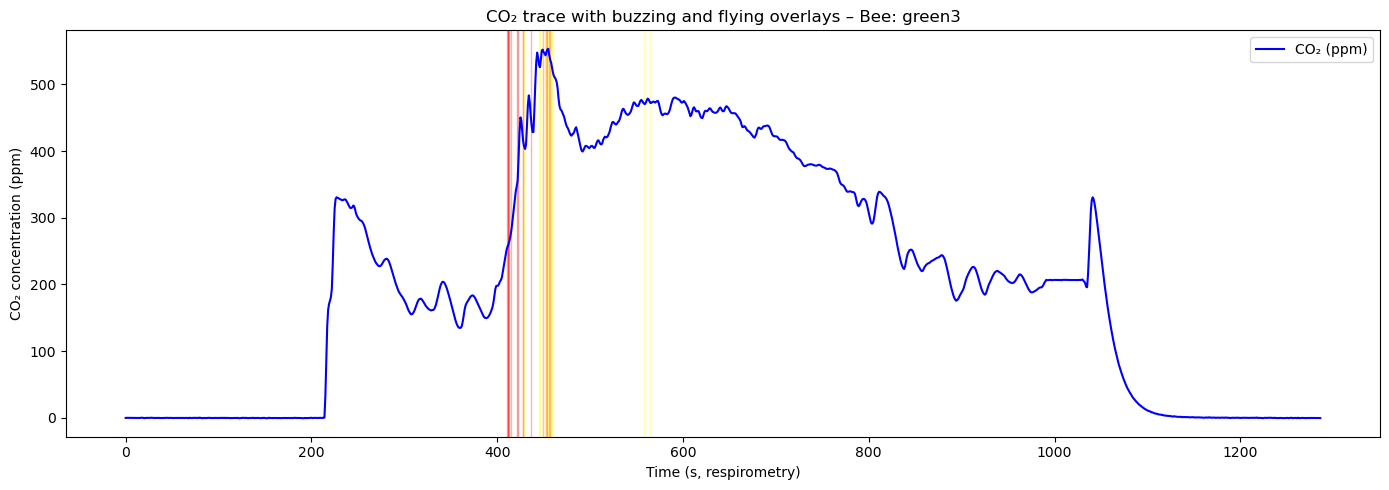

In [68]:
# --- EXAMPLE USAGE ---
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="green3")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-20-2025_001_green4_flower_corrected_secfromstart


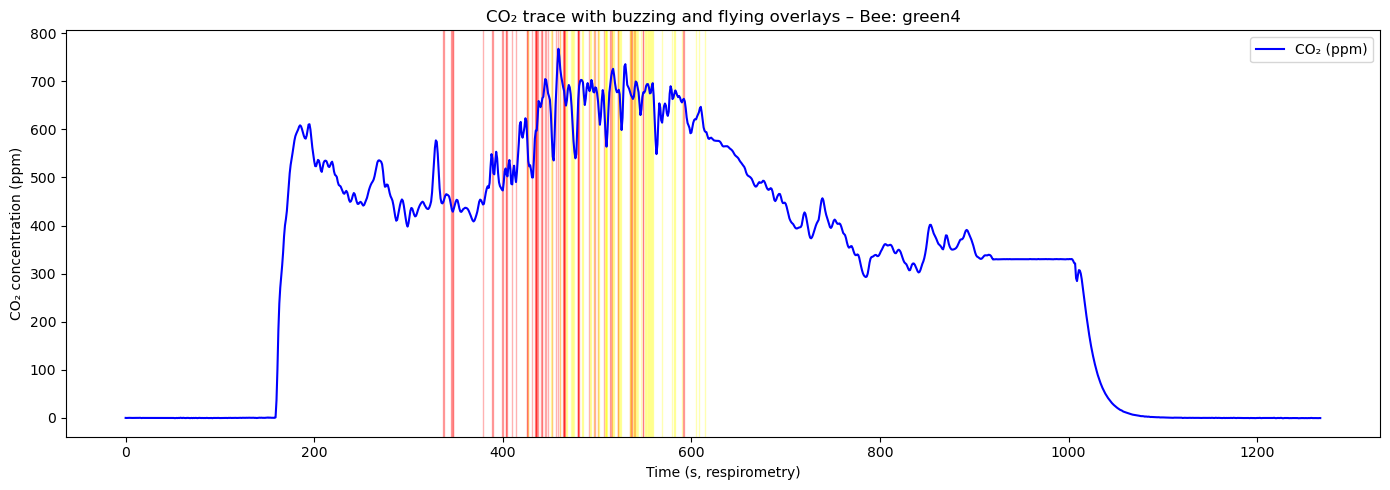

In [69]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="green4")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_23-03-2025_001_green5_flower_corrected_secfromstart


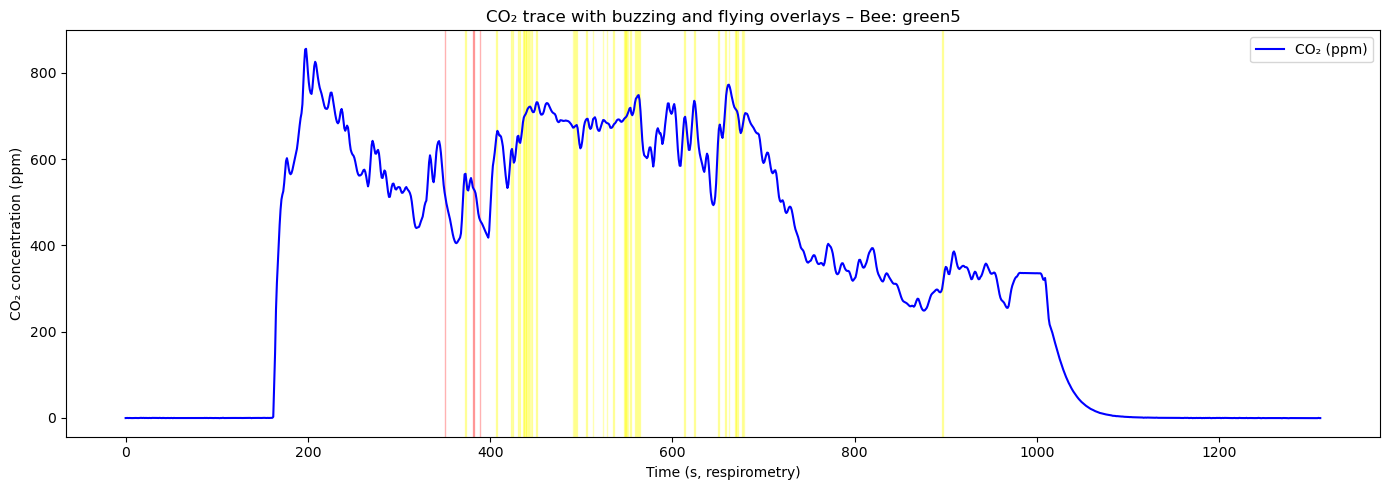

In [70]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="green5")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-10-2025_001_red31_flower_corrected_secfromstart


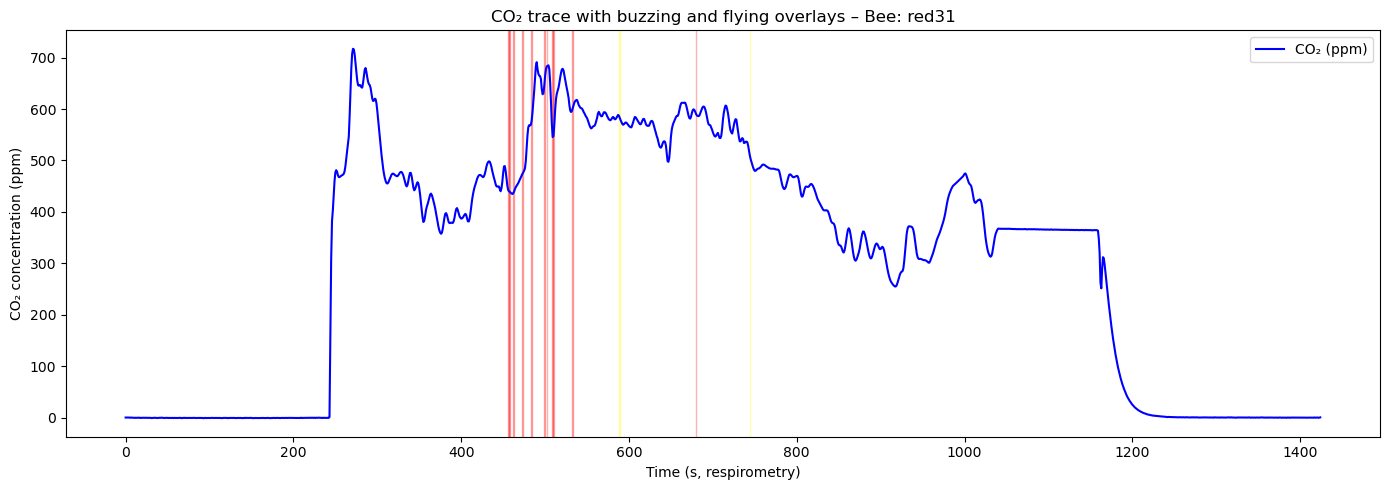

In [71]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="red31")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-10-2025_001_unmarked3_flower_corrected_secfromstart


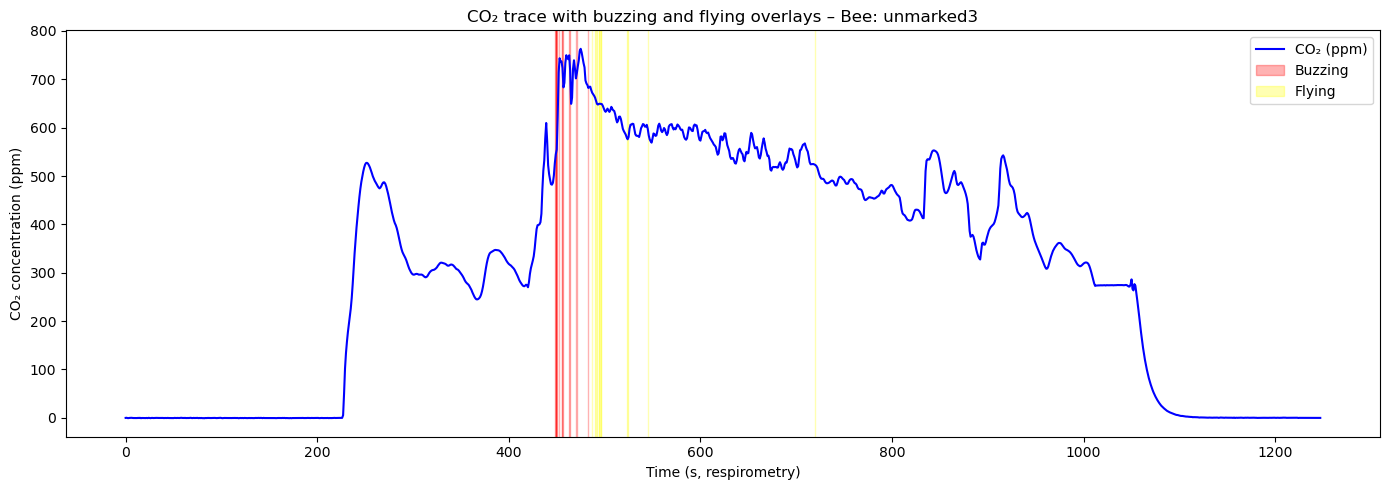

In [72]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked3")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-12-2025_001_unmarked302_flower_corrected_secfromstart


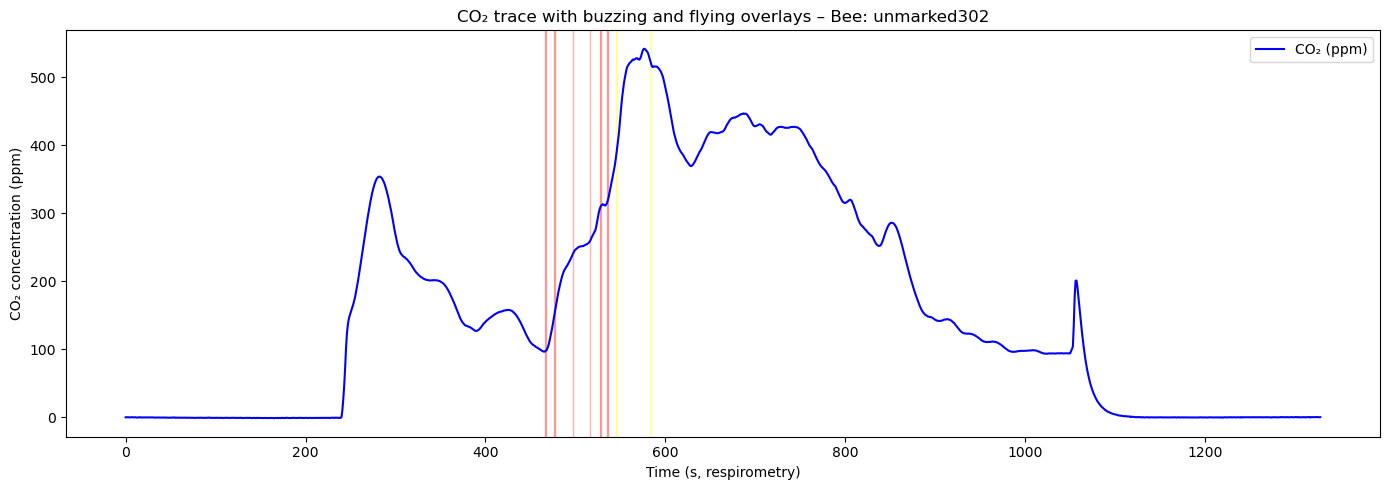

In [73]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked302")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-12-2025_001_unmarked303_flower_corrected_secfromstart


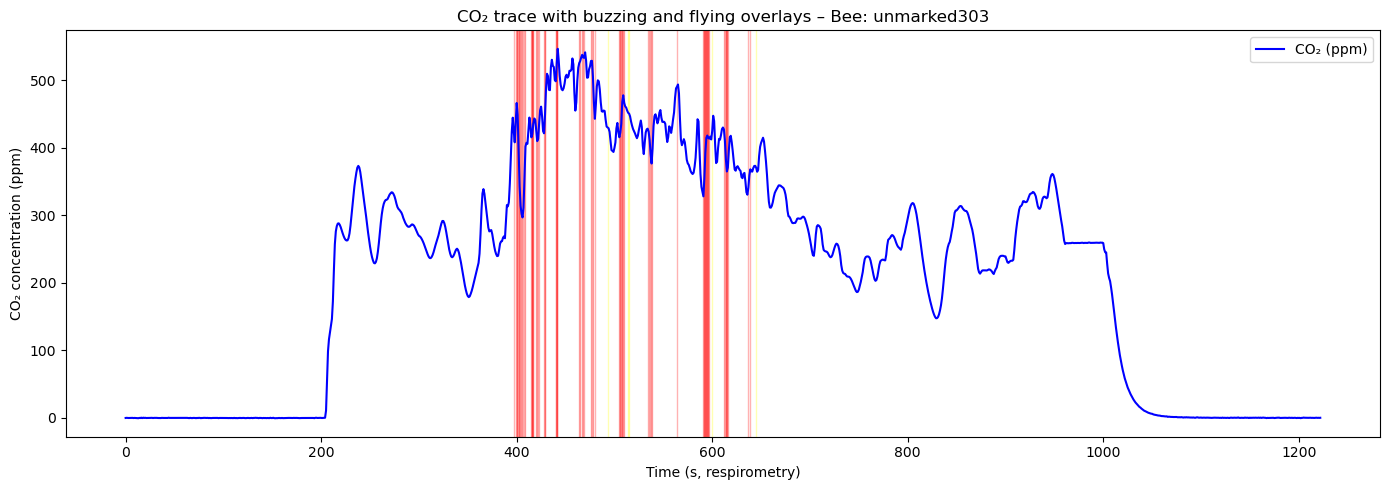

In [74]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked303")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-10-2025_001_unmarked33_flower_corrected_secfromstart


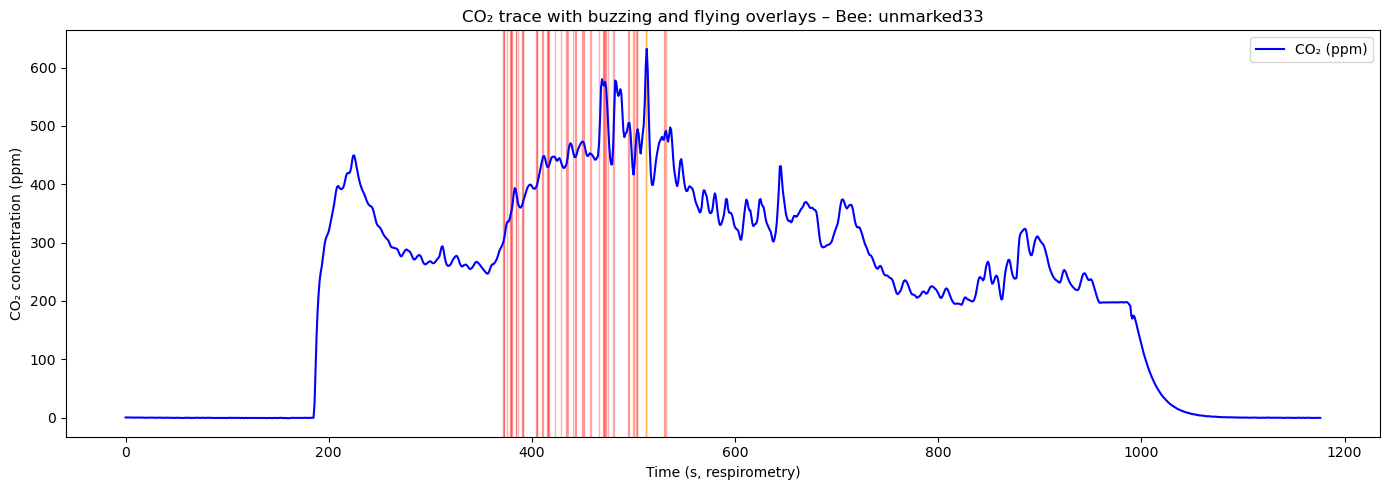

In [76]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked33")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-10-2025_001_unmarked34_flower_corrected_secfromstart


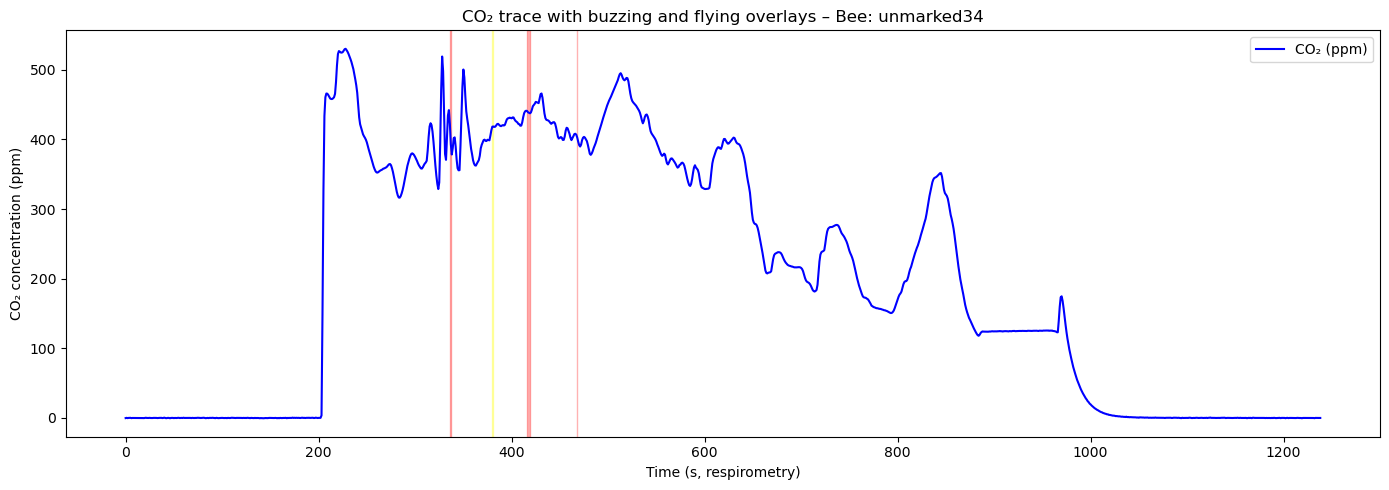

In [77]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked34")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-11-2025_001_unmarked38_flower_corrected_secfromstart


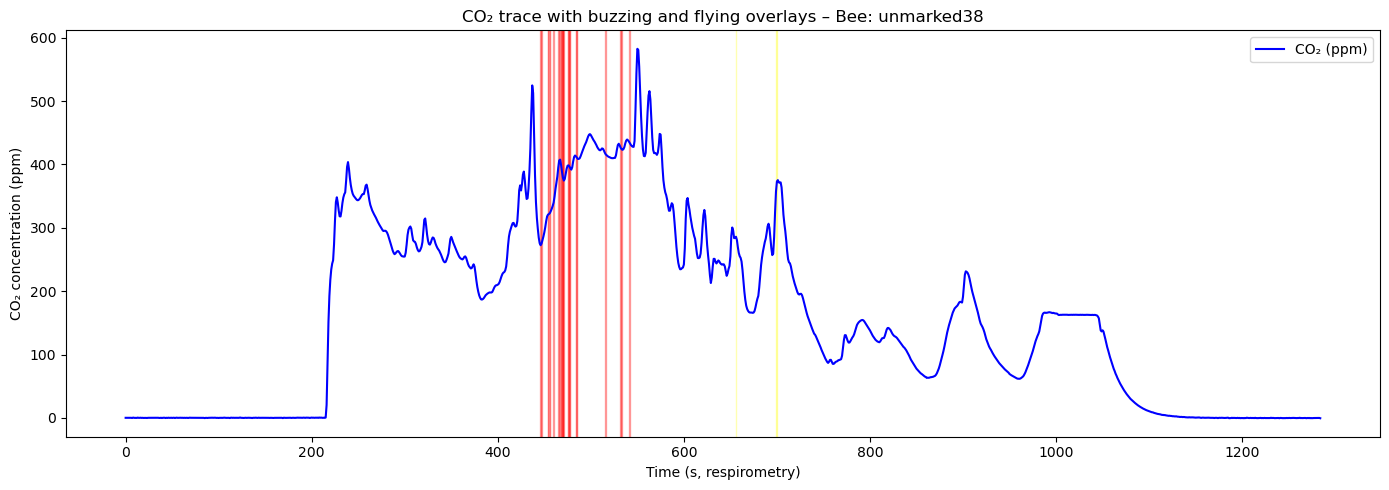

In [78]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked38")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_20-03-2025_001_unmarked4_flower_corrected_secfromstart


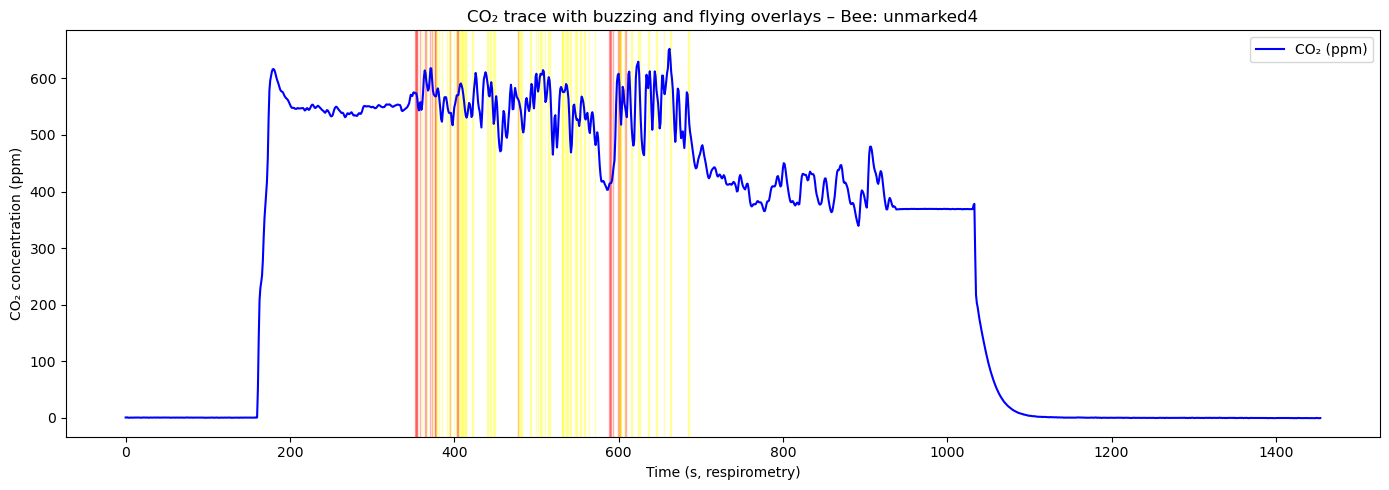

In [79]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked4")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-20-2025_001_unmarked40_flower_corrected_secfromstart


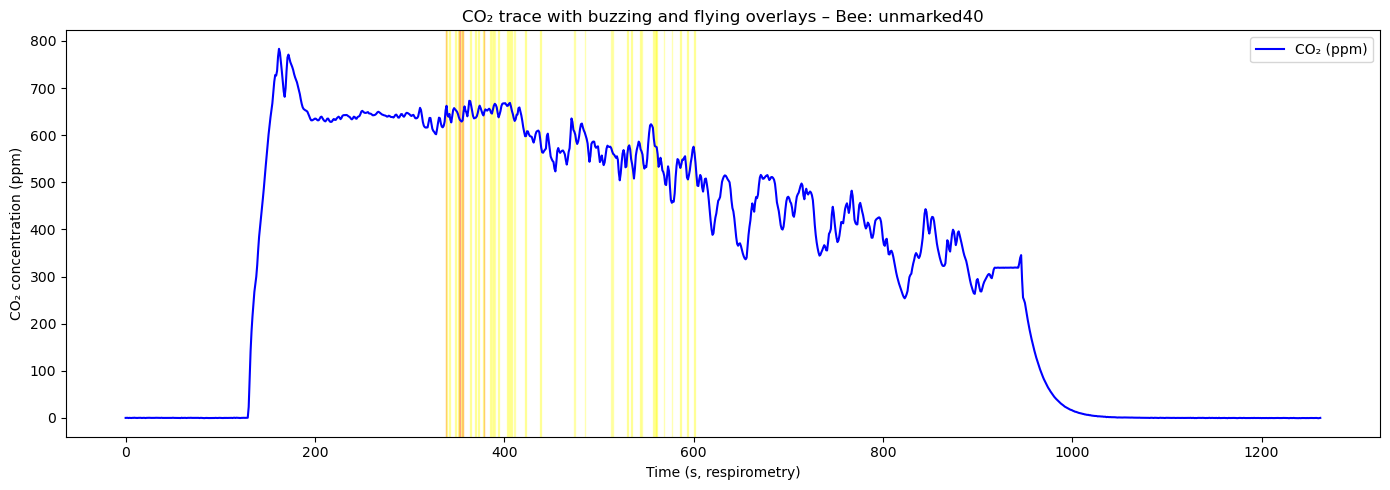

In [80]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked40")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-20-2025_001_unmarked41_flower_corrected_secfromstart


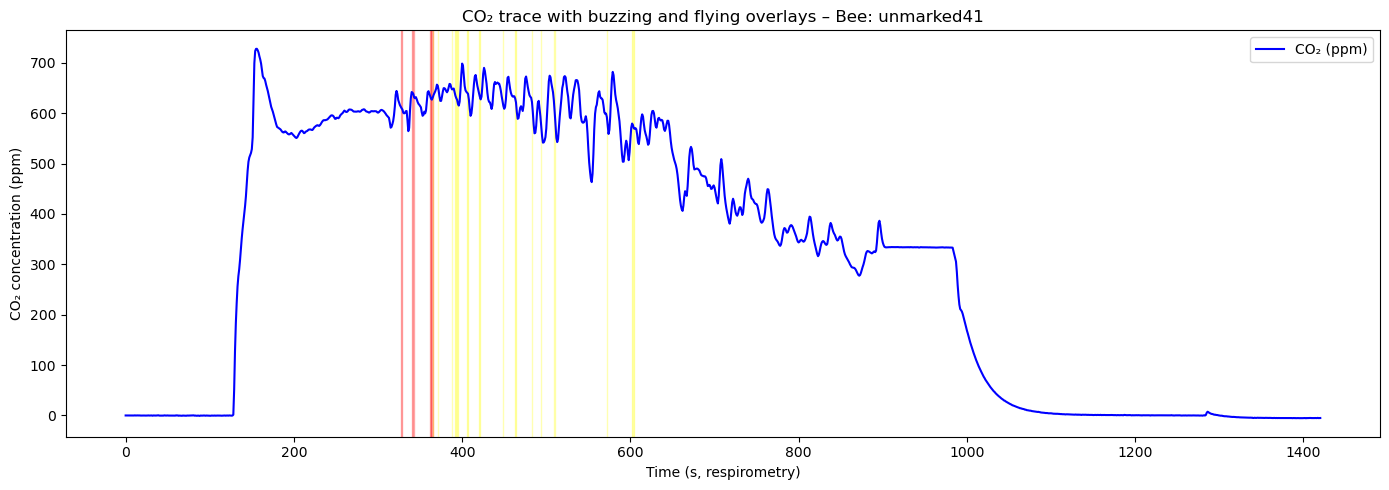

In [81]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked41")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-20-2025_001_unmarked42_flower_corrected_secfromstart


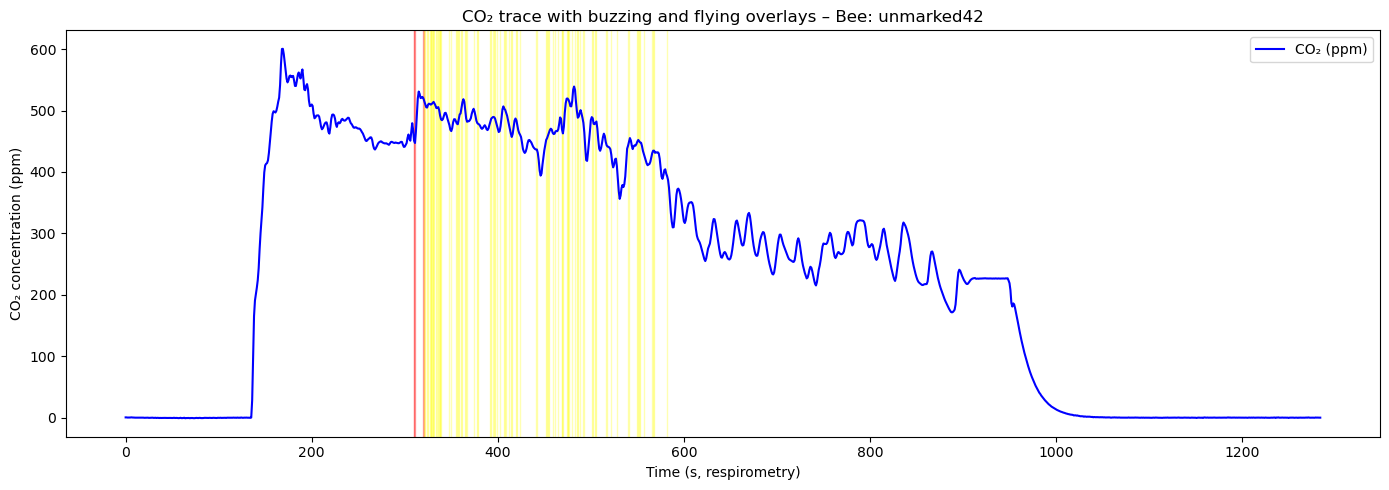

In [82]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked42")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-20-2025_001_unmarked44_flower_corrected_secfromstart


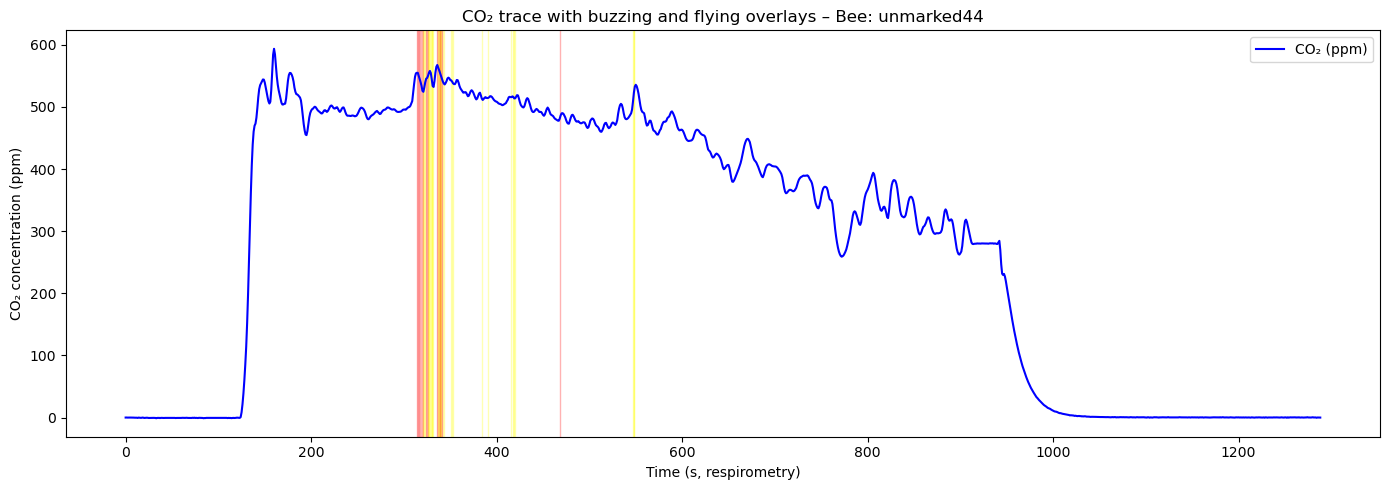

In [83]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked44")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-20-2025_001_unmarked46_flower_corrected_secfromstart


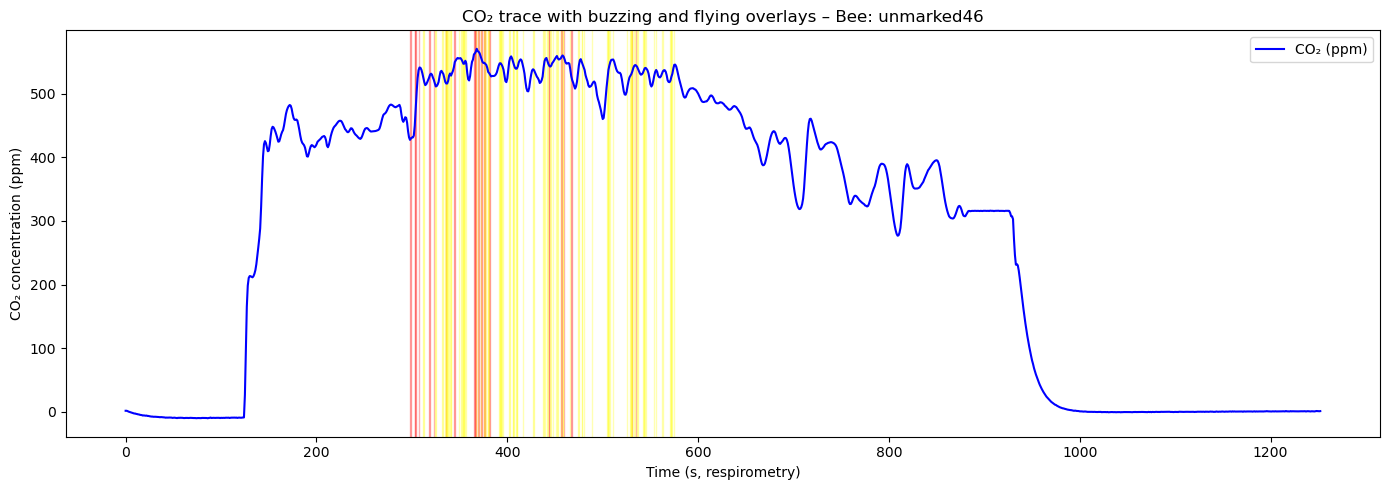

In [84]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked46")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-20-2025_001_unmarked47_flower_corrected_secfromstart


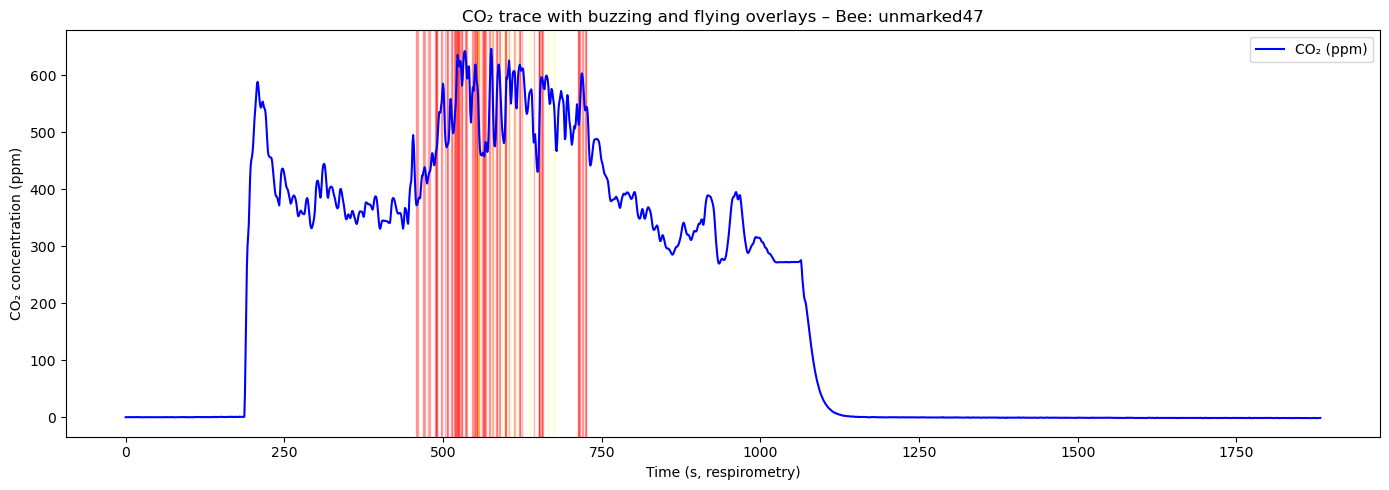

In [85]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked47")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_03-20-2025_001_unmarked48_flower_corrected_secfromstart


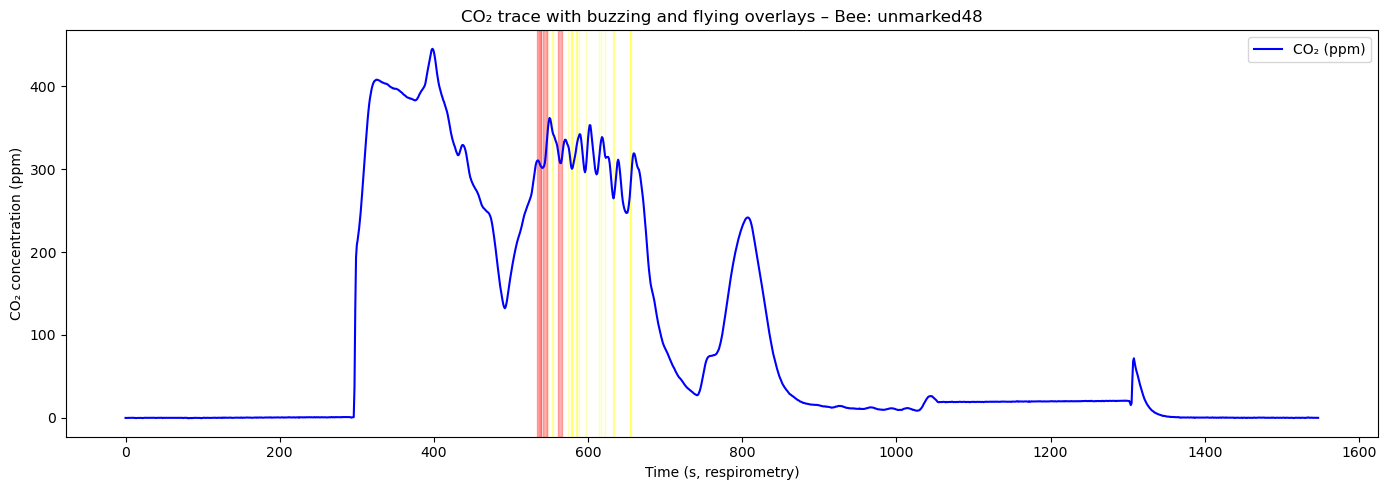

In [86]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked48")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_23-03-2025_001_unmarked5_flower_corrected_secfromstart


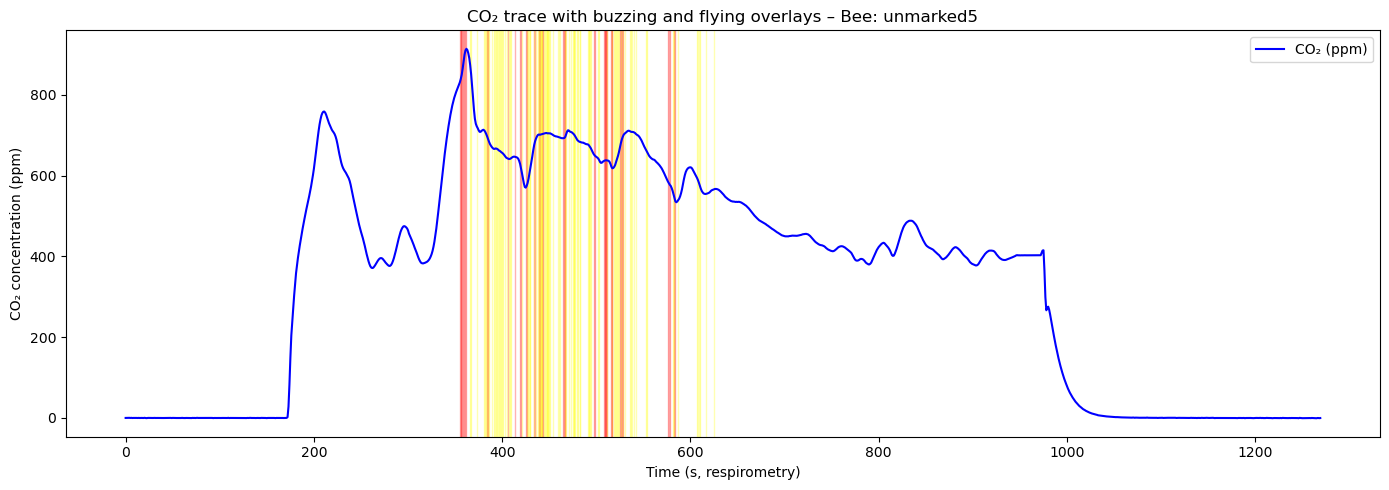

In [87]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked5")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_23-03-2025_001_unmarked50_flower_corrected_secfromstart


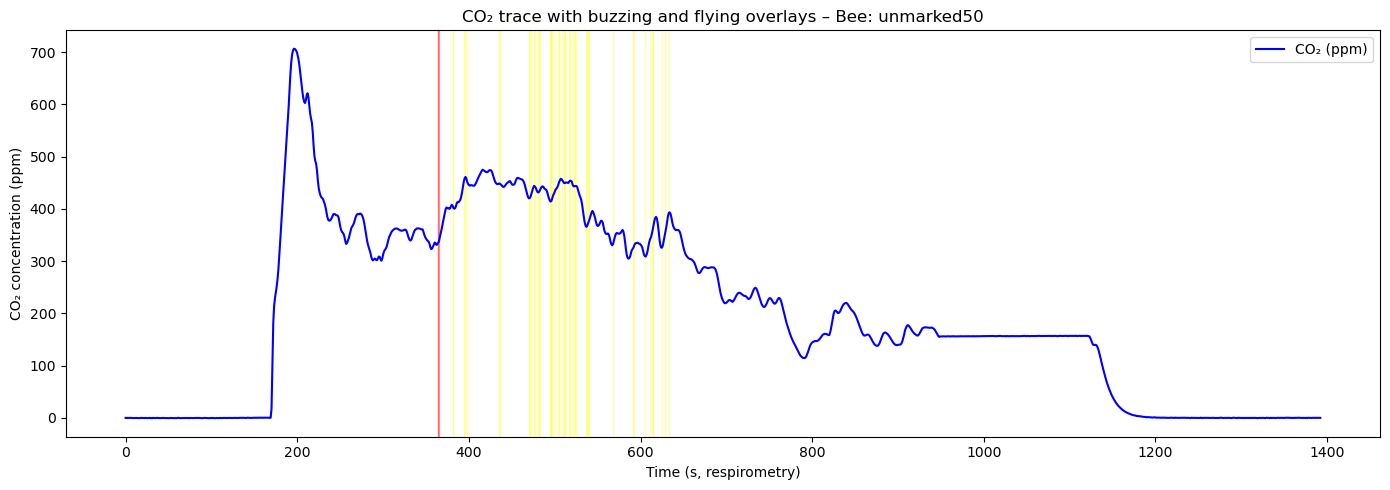

In [88]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked50")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_24-03-2025_001_unmarked500_flower_corrected_secfromstart


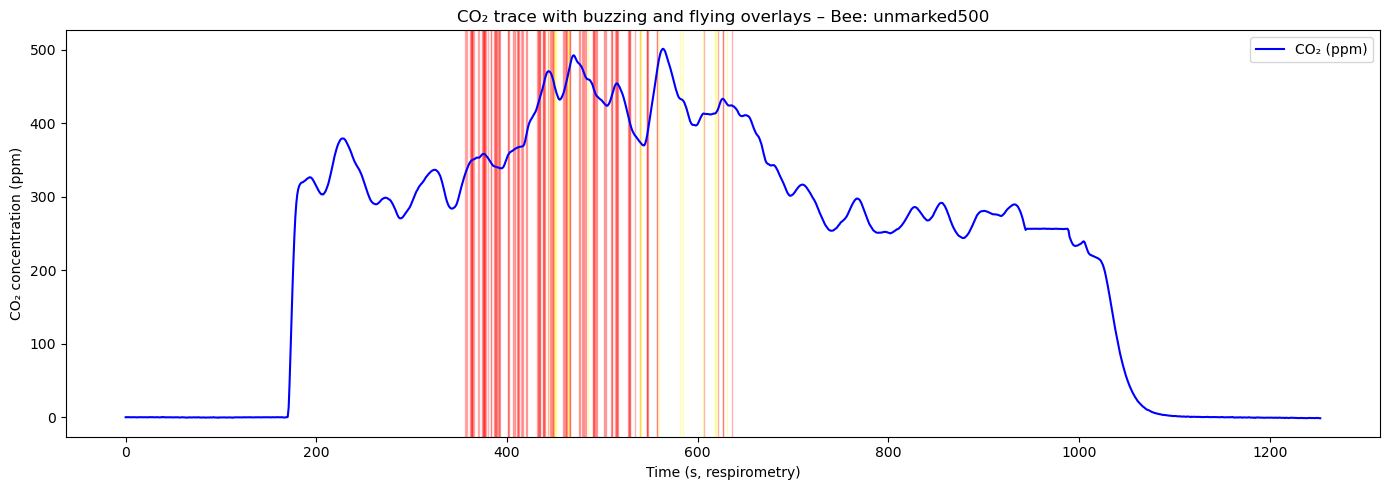

In [89]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked500")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_24-03-2025_001_unmarked501_flower_corrected_secfromstart


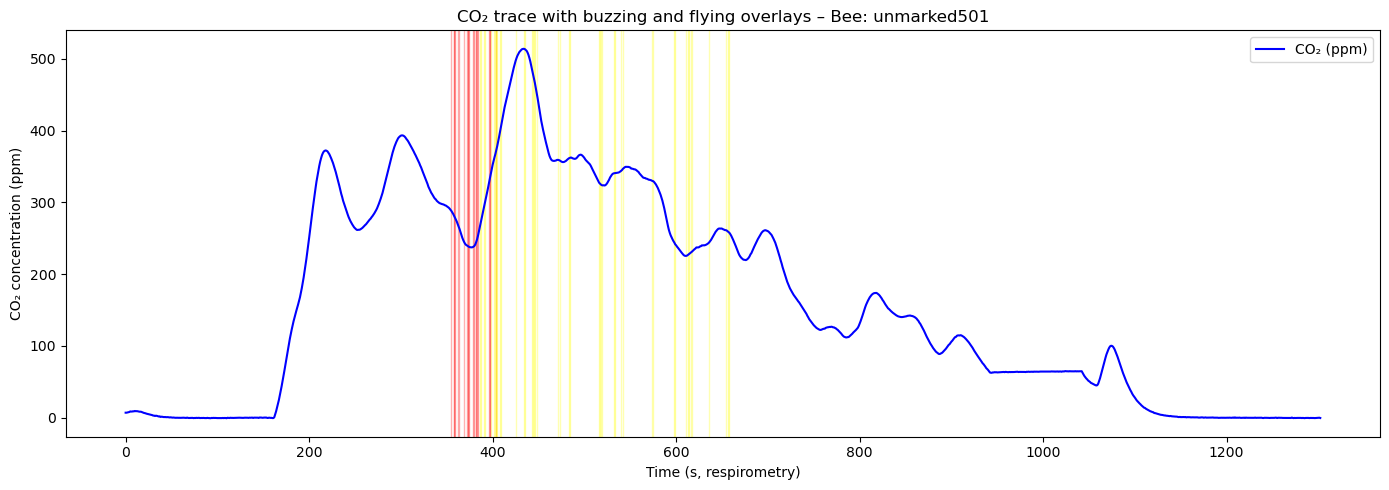

In [90]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked501")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_23-03-2025_001_unmarked51_flower_corrected_secfromstart


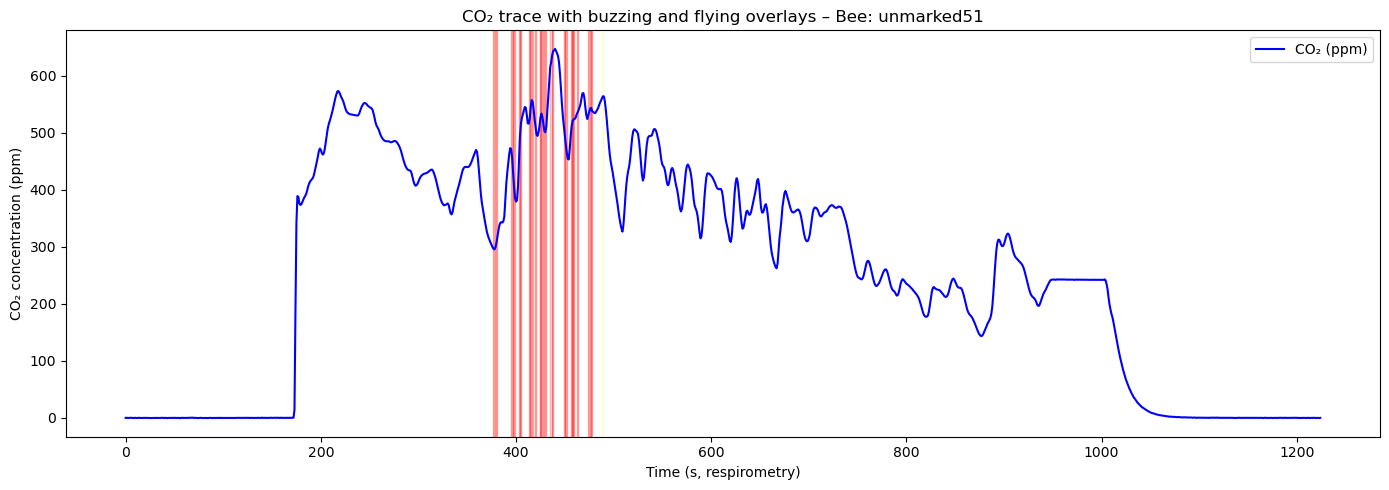

In [91]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked51")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_23-03-2025_001_unmarked52_flower_corrected_secfromstart


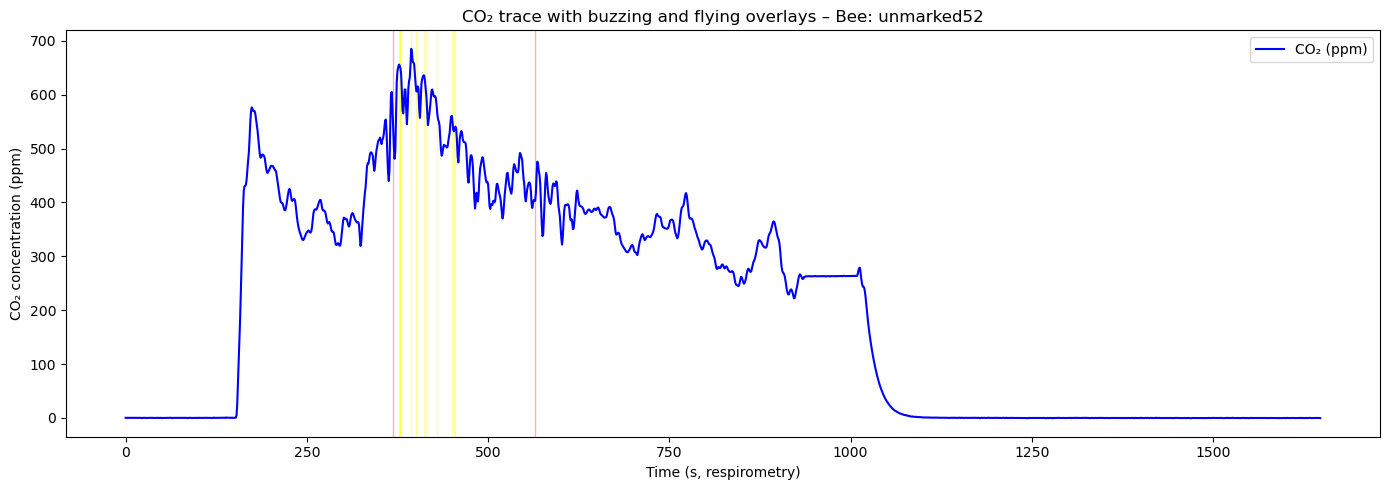

In [92]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked52")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_23-03-2025_001_unmarked56_flower_corrected_secfromstart


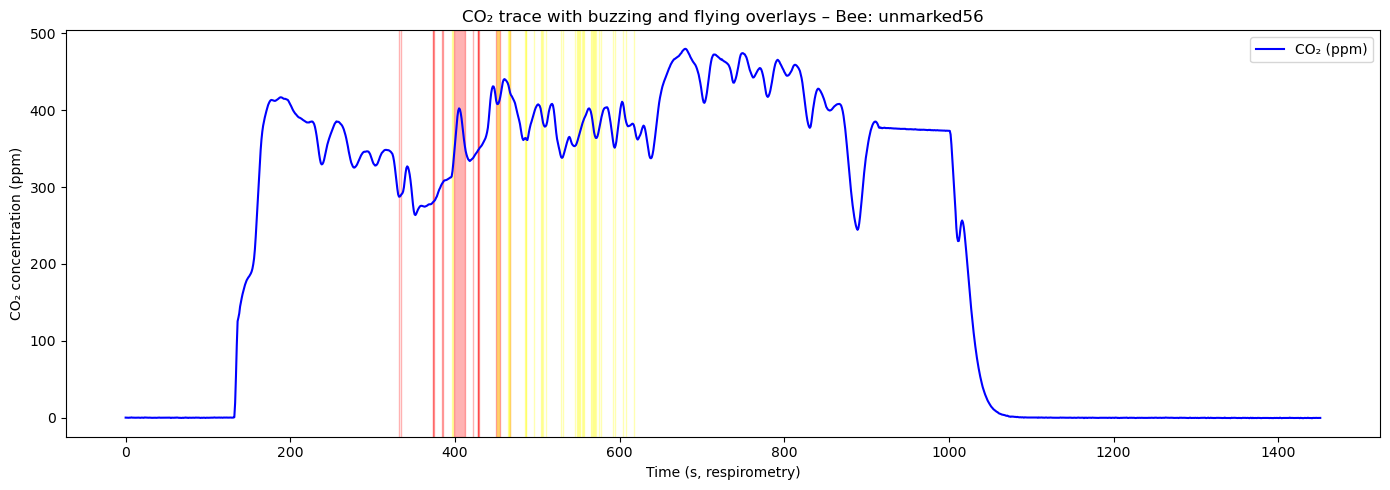

In [93]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked56")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_23-03-2025_001_unmarked57_flower_corrected_secfromstart


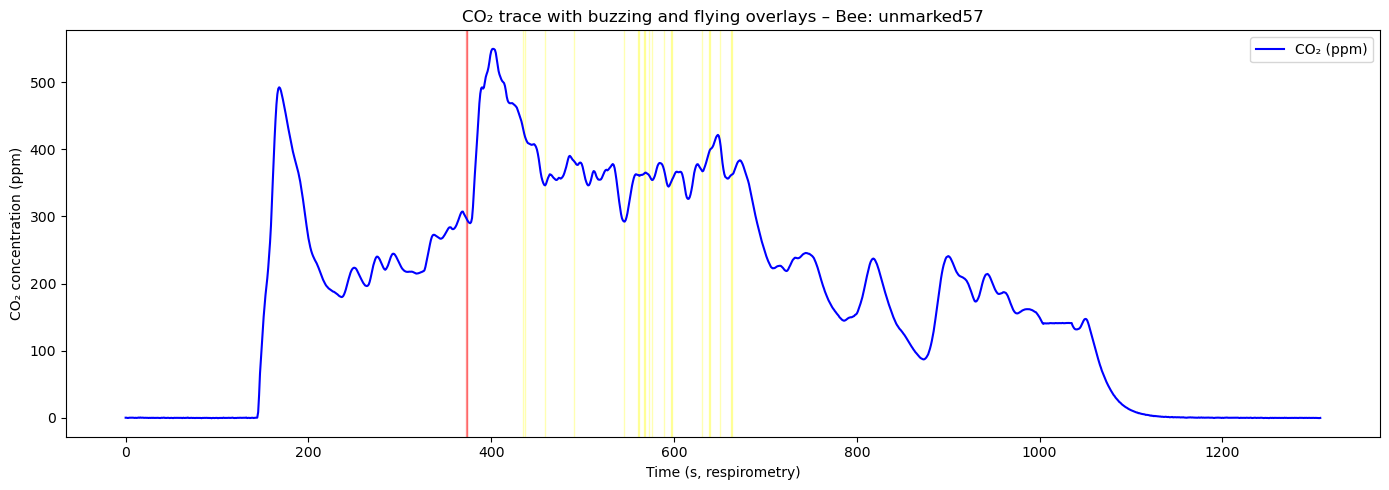

In [94]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked57")


📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_24-03-2025_001_unmarked59_flower_corrected_secfromstart


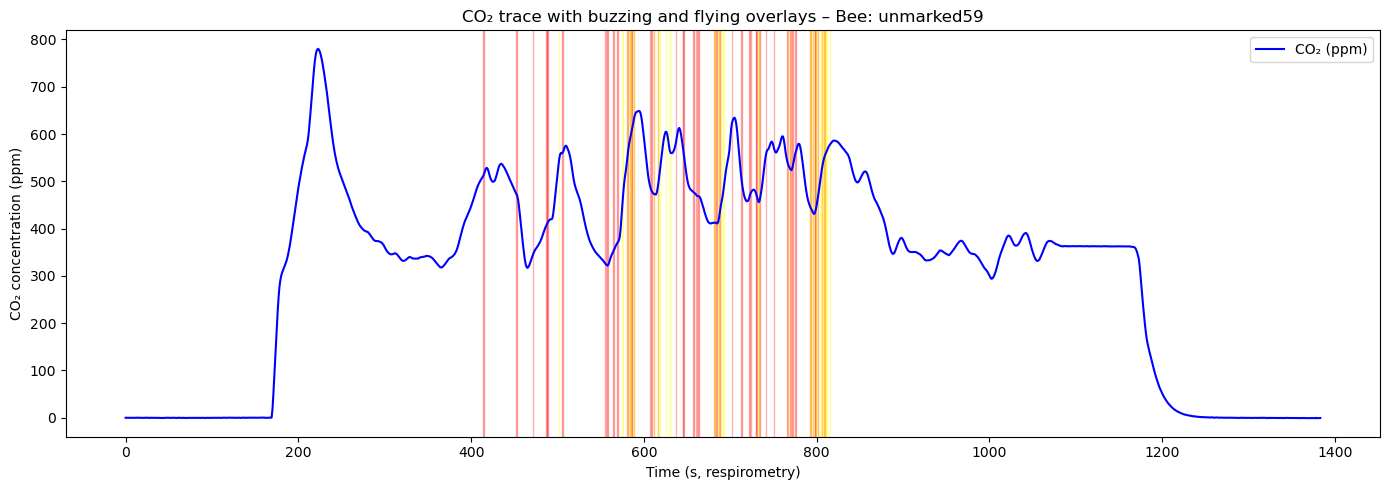

In [95]:
plot_co2_with_buzzes_and_flights(buzz_df, bouts_df, meta_df, bee_id="unmarked59")

In [97]:
# --- Prepare buzzing bouts ---
buzz_df = buzz_df.copy()
buzz_df["event_type"] = "buzz"

# --- Prepare flying bouts (from bouts_df) ---
bouts_df = bouts_df.copy()
bouts_df["event_type"] = "flight"

# --- Combine and print ---
combined_events = pd.concat([buzz_df, bouts_df], ignore_index=True)
combined_events = combined_events.sort_values(by=["BeeID", "start_respi_s"])

# Print respirometry-aligned events per bee
for bee_id, group in combined_events.groupby("BeeID"):
    print(f"\n🐝 Bee: {bee_id}")
    for _, row in group.iterrows():
        start = round(row["start_respi_s"], 2)
        stop = round(row["stop_respi_s"], 2)
        event = row["event_type"]
        print(f"  - {event.title()} from {start}s to {stop}s")


🐝 Bee: green3
  - Buzz from 410.89s to 411.05s
  - Buzz from 411.15s to 411.32s
  - Buzz from 411.91s to 412.02s
  - Buzz from 412.11s to 412.24s
  - Buzz from 414.55s to 415.16s
  - Buzz from 421.0s to 422.44s
  - Buzz from 427.25s to 427.5s
  - Buzz from 427.52s to 428.2s
  - Flight from 427.84s to 428.31s
  - Buzz from 436.59s to 436.71s
  - Flight from 444.61s to 446.11s
  - Buzz from 449.29s to 449.56s
  - Flight from 449.34s to 449.71s
  - Flight from 451.47s to 452.47s
  - Buzz from 452.82s to 453.45s
  - Flight from 454.21s to 454.41s
  - Flight from 455.21s to 455.37s
  - Buzz from 455.87s to 456.31s
  - Flight from 456.44s to 456.77s
  - Flight from 459.51s to 460.34s
  - Flight from 558.21s to 558.37s
  - Flight from 564.71s to 564.84s

🐝 Bee: green4
  - Buzz from 336.97s to 337.26s
  - Buzz from 345.12s to 345.72s
  - Buzz from 346.71s to 347.16s
  - Buzz from 347.18s to 347.41s
  - Buzz from 379.11s to 379.22s
  - Buzz from 389.03s to 389.76s
  - Buzz from 399.62s to 400.

In [98]:
# Prep buzz_df for export
buzz_export = buzz_df[["BeeID", "start_respi_s", "stop_respi_s"]].copy()
buzz_export["event_type"] = "buzz"

# Prep bouts_df (flying) for export
bouts_export = bouts_df[["BeeID", "start_respi_s", "stop_respi_s"]].copy()
bouts_export["event_type"] = "flight"

# Combine both
combined_export = pd.concat([buzz_export, bouts_export], ignore_index=True)
combined_export = combined_export.sort_values(by=["BeeID", "start_respi_s"])

# Optional: add duration
combined_export["duration_s"] = combined_export["stop_respi_s"] - combined_export["start_respi_s"]

# Save to CSV
combined_export.to_csv(
    r"C:\Users\labadmin\Documents\Uppsala analyses\clean_bout_candidates.csv",
    index=False,
    encoding="utf-8"
)

print("✅ Clean bout candidates saved as CSV.")

✅ Clean bout candidates saved as CSV.


In [99]:
import pandas as pd

# --- Load your data ---
clean_bouts_df = pd.read_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\clean_bout_candidates.csv")
video_sync_df = pd.read_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\BORIS manual labelling\respirometry syncing\respirometry_syncing.csv")

# --- Extract BeeID from 'Observation id' in the syncing file ---
video_sync_df["BeeID"] = video_sync_df["Observation id"].str.split("-").str[2].str.lower()

# --- Define the air travel delay you used during alignment ---
AIR_TRAVEL_DELAY = 12.84  # seconds

# --- Merge syncing info into the clean bouts ---
merged_df = clean_bouts_df.merge(
    video_sync_df[["BeeID", "Start (s)"]],
    on="BeeID",
    how="left"
)

# --- Compute video time from respirometry time ---
merged_df["start_video_time"] = (
    merged_df["start_respi_s"] - AIR_TRAVEL_DELAY + merged_df["Start (s)"]
)

merged_df["stop_video_time"] = (
    merged_df["stop_respi_s"] - AIR_TRAVEL_DELAY + merged_df["Start (s)"]
)

# --- Save the result if needed ---
merged_df.to_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\clean_bouts_with_video_times.csv", index=False)

print("✅ Done! Video times added and saved.")

✅ Done! Video times added and saved.


In [103]:
import plotly.graph_objs as go

def plot_co2_with_buzzes_and_flights_plotly(buzz_df, bouts_df, meta_df, bee_id):
    bee_id = bee_id.lower()
    meta_row = meta_df[meta_df["BeeID"] == bee_id]

    if meta_row.empty or "respi_file" not in meta_row.columns or pd.isna(meta_row["respi_file"].values[0]):
        print(f"❌ No matching respirometry file found for bee '{bee_id}'")
        return

    file_name = str(meta_row["respi_file"].values[0])
    file_path = respirometry_dir / file_name

    print(f"📄 Loading respirometry file: {file_path}")
    try:
        trace = pd.read_csv(file_path, sep=None, engine="python")
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return

    # Convert CO2 to ppm
    if "CO2" in trace.columns:
        trace["CO2_ppm"] = trace["CO2"] * 10000
    elif "CO2_percent" in trace.columns:
        trace["CO2_ppm"] = trace["CO2_percent"] * 10000
    else:
        print("❌ Missing CO₂ column. Expected 'CO2' or 'CO2_percent'.")
        return

    if "Seconds" not in trace.columns:
        print("❌ Missing 'Seconds' column.")
        return

    buzzes = buzz_df[buzz_df["BeeID"] == bee_id]
    flights = bouts_df[bouts_df["BeeID"] == bee_id]

    fig = go.Figure()

    # CO₂ trace
    fig.add_trace(go.Scatter(
        x=trace["Seconds"],
        y=trace["CO2_ppm"],
        mode='lines',
        name='CO₂ (ppm)',
        line=dict(color='black')
    ))

    # Add buzzing bouts
    for _, row in buzzes.iterrows():
        fig.add_vrect(
            x0=row["start_respi_s"], x1=row["stop_respi_s"],
            fillcolor="red", opacity=0.3,
            layer="below", line_width=0,
            annotation_text="Buzzing", annotation_position="top left"
        )

    # Add flying bouts
    for _, row in flights.iterrows():
        fig.add_vrect(
            x0=row["start_respi_s"], x1=row["stop_respi_s"],
            fillcolor="blue", opacity=0.2,
            layer="below", line_width=0,
            annotation_text="Flying", annotation_position="top left"
        )

    fig.update_layout(
        title=f"Interactive CO₂ Trace with Buzzing and Flying Bouts – Bee: {bee_id}",
        xaxis_title="Time (s)",
        yaxis_title="CO₂ concentration (ppm)",
        hovermode="x unified",
        xaxis=dict(rangeslider_visible=True),
        height=600
    )

    fig.show()

In [131]:
plot_co2_with_buzzes_and_flights_plotly(buzz_df, bouts_df, meta_df, bee_id="unmarked59")

📄 Loading respirometry file: D:\Respirometry\Bumblebee\flying\Data_24-03-2025_001_unmarked59_flower_corrected_secfromstart
